## Классификация RUL различными методами

TO DO:
- LogReg
- Random Forest
- Naive Bayes (?)
- Gradient Boosting (sklearn, xgboost, catboost)
- LSTM
- CNN 
    - реккурентные графики
    - Gramian Angular Fields
    - Markov Transition Fields 
    

#### Импорт библиотек

In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
from PIL import Image
import itertools
from time import time

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array

from tensorflow import GradientTape
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

#### Чтение данных

In [9]:
df = pd.read_parquet('data/train_data.parquet')

In [3]:
test = pd.read_parquet('data/test_data.parquet')

In [6]:
df_feat = pd.read_parquet('data/train_data_feat.parquet')

In [7]:
test_feat = pd.read_parquet('data/test_data_feat.parquet')

#### Чтение изображений

In [27]:
xtrain_rec = np.load('data/xtrain_img_rec.npy')
xtest_rec = np.load('data/xtest_img_rec.npy')

xtrain_gaf = np.load('data/xtrain_img_gaf.npy')
xtest_gaf = np.load('data/xtest_img_gaf.npy')

Отшкалируем данные и удалим наны

In [10]:
# params = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
#        's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
#        's15', 's16', 's17', 's18', 's19', 's20', 's21']
# noninform_feat = ['s19', 's18', 's16', 's10', 's5', 's6', 's1', 'setting1', 'setting2', 'setting3']

# параметры отобранные анализом данных
params = ['setting1', 'setting2', 's2', 's3', 's4', 's7', 
          's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 
          's20', 's21']

# параметры отобранные случайным лесом
feat_imp = pd.read_parquet('data/feature_imp_class.parquet')
params_imp = feat_imp.feature[:50]

In [11]:
scaler = StandardScaler()
df[params] = scaler.fit_transform(df[params])

In [12]:
test[params] = scaler.fit_transform(test[params])

In [13]:
df_feat[params_imp] = scaler.fit_transform(df_feat[params_imp])

In [14]:
test_feat[params_imp] = scaler.fit_transform(test_feat[params_imp])

### Нейронные сети

#### Рекуррентные нейронные сети 

In [36]:
xtrain = np.load('data/xtrain.npy')
xtest = np.load('data/xtest.npy')

ytrain = np.load('data/ytrain.npy')
ytest = np.load('data/ytest.npy')

xtrain_feat = np.load('data/xtrain_feat.npy')
xtest_feat = np.load('data/xtest_feat.npy')

In [46]:
def LSTM_NN(params):
    LAYERS = [8, 8, 8, 3]  # число юнитов в слоях              
    seq_len = 50

    model = Sequential()
    model.add(LSTM(input_shape=(seq_len, len(params)), 
                   units=LAYERS[0],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=True, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[1],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=True, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(LSTM(units=LAYERS[2],
                   activation='tanh', 
                   recurrent_activation='hard_sigmoid',
                   kernel_regularizer=l2(3e-2), 
                   recurrent_regularizer=l2(3e-2),
                   return_sequences=False, return_state=False,
                   stateful=False, unroll=False ))
    model.add(BatchNormalization())
    model.add(Dense(units=LAYERS[3], activation='sigmoid'))


    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy'],
                  optimizer=Adam(lr=0.01))
    
    print(model.summary())
    return model

In [30]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

In [47]:
BATCH_SIZE = 200
EPOCHS = 20

model = LSTM_NN(params)

History = model.fit(np.asarray(xtrain), np.asarray(ytrain),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[lr_decay, early_stop])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 8)             800       
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 8)             32        
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 8)             544       
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 8)             32        
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 544       
_________________________________________________________________
batch_normalization_5 (Batch (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [48]:
model.evaluate(xtest, ytest, verbose=0)[1]

0.88295335

In [49]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest)))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      6922
           1       0.44      0.71      0.54      1180
           2       0.15      1.00      0.26        60

    accuracy                           0.83      8162
   macro avg       0.53      0.85      0.57      8162
weighted avg       0.91      0.83      0.85      8162



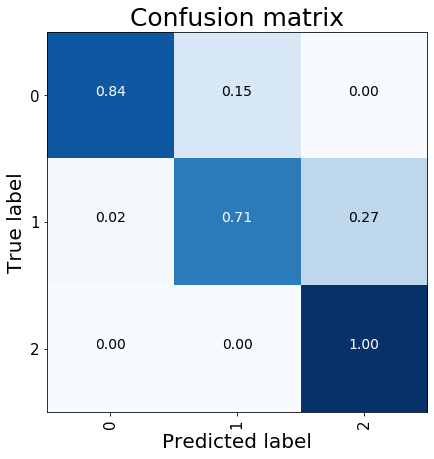

In [50]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

#### Сверточные нейронные сети (СNN)

In [55]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(50,50,len(params)), name='layer_conv1'))
model.add(Conv2D(32, (3, 3), activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool1'))
model.add(Dropout(0.25, name='drop1'))

model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv3'))
model.add(Conv2D(64, (3,3), activation='relu', name='layer_conv4'))
model.add(MaxPooling2D(pool_size=(2,2), name='max_pool2'))
model.add(Dropout(0.25, name='drop2'))

model.add(Flatten(name='flat1'))
model.add(Dense(256, activation='relu', name='dense1'))
model.add(Dropout(0.5, name='drop3'))
model.add(Dense(3, activation='softmax', name='dense2'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)         

In [56]:
BATCH_SIZE = 200
EPOCHS = 20

history = model.fit(xtrain_rec,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/20
12504/12504 [==============================] - 162s 13ms/sample - loss: 1.1219 - acc: 0.6218 - val_loss: 0.7422 - val_acc: 0.6796
Epoch 2/20
12504/12504 [==============================] - 153s 12ms/sample - loss: 0.4512 - acc: 0.8137 - val_loss: 0.3977 - val_acc: 0.8420
Epoch 3/20
12504/12504 [==============================] - 136s 11ms/sample - loss: 0.3653 - acc: 0.8484 - val_loss: 0.3509 - val_acc: 0.8590
Epoch 4/20
12504/12504 [==============================] - 133s 11ms/sample - loss: 0.3205 - acc: 0.8634 - val_loss: 0.3568 - val_acc: 0.8423
Epoch 5/20
12504/12504 [==============================] - 134s 11ms/sample - loss: 0.3069 - acc: 0.8711 - val_loss: 0.3603 - val_acc: 0.8395
Epoch 6/20
12504/12504 [==============================] - 132s 11ms/sample - loss: 0.2754 - acc: 0.8837 - val_loss: 0.3557 - val_acc: 0.8606
Epoch 7/20
12504/12504 [==============================] - 123s 10ms/sample - loss: 0.2407 - acc: 0.9000 -

In [49]:
model.evaluate(xtest_img, ytest, verbose=0)[1]

0.8719677

In [50]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest_img)))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      6922
           1       0.54      0.72      0.62      1180
           2       0.32      0.72      0.44        60

    accuracy                           0.87      8162
   macro avg       0.61      0.78      0.66      8162
weighted avg       0.90      0.87      0.88      8162



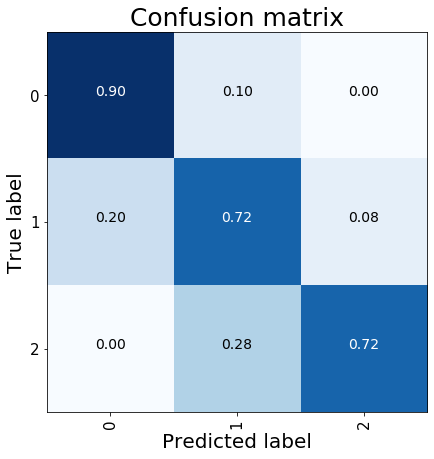

In [51]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest_img))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Gramian Angular Field

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_conv1 (Conv2D)         (None, 48, 48, 32)        4640      
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 23, 23, 32)        0         
_________________________________________________________________
drop1 (Dropout)              (None, 23, 23, 32)        0         
_________________________________________________________________
layer_conv3 (Conv2D)         (None, 21, 21, 64)        18496     
_________________________________________________________________
layer_conv4 (Conv2D)         (None, 19, 19, 64)        36928     
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 9, 9, 64)         

In [58]:
BATCH_SIZE = 200
EPOCHS = 10

history = model.fit(xtrain_gaf,
                   ytrain,
                   batch_size=BATCH_SIZE, 
                   epochs=EPOCHS,
                   validation_split=0.2,
                   verbose=1)

Train on 12504 samples, validate on 3127 samples
Epoch 1/10
12504/12504 [==============================] - 134s 11ms/sample - loss: 0.7793 - acc: 0.6507 - val_loss: 0.5311 - val_acc: 0.7988
Epoch 2/10
12504/12504 [==============================] - 101s 8ms/sample - loss: 0.4943 - acc: 0.7842 - val_loss: 0.5149 - val_acc: 0.7960
Epoch 3/10
12504/12504 [==============================] - 100s 8ms/sample - loss: 0.4331 - acc: 0.8145 - val_loss: 0.4662 - val_acc: 0.8203
Epoch 4/10
12504/12504 [==============================] - 106s 8ms/sample - loss: 0.4153 - acc: 0.8214 - val_loss: 0.4509 - val_acc: 0.8343
Epoch 5/10
12504/12504 [==============================] - 102s 8ms/sample - loss: 0.3778 - acc: 0.8409 - val_loss: 0.4386 - val_acc: 0.8324
Epoch 6/10
12504/12504 [==============================] - 105s 8ms/sample - loss: 0.3484 - acc: 0.8536 - val_loss: 0.4628 - val_acc: 0.8260
Epoch 7/10
12504/12504 [==============================] - 101s 8ms/sample - loss: 0.3331 - acc: 0.8631 - val_l

In [61]:
model.evaluate(xtest_gaf, ytest, verbose=0)[1]

0.79576087

In [63]:
print(classification_report(np.where(ytest != 0)[1], model.predict_classes(xtest_gaf)))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89      6922
           1       0.38      0.52      0.44      1180
           2       0.13      0.88      0.22        60

    accuracy                           0.80      8162
   macro avg       0.49      0.75      0.52      8162
weighted avg       0.86      0.80      0.82      8162



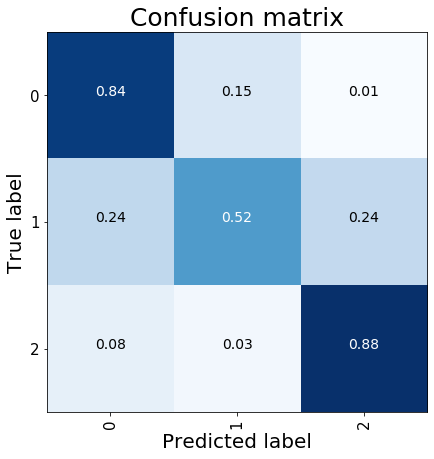

In [64]:
cnf_matrix = confusion_matrix(np.where(ytest != 0)[1], model.predict_classes(xtest_gaf))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(ytest != 0)[1]), title="Confusion matrix")
plt.show()

Визуализация фильтров

In [75]:
layer_variables = model.get_layer('conv2d_4').get_weights()

weights = layer_variables[0]
biases = layer_variables[1]

w = np.array(weights)
w.shape

(3, 3, 16, 32)

In [76]:
w = np.moveaxis(w, 2, 0)
w = np.moveaxis(w, 3, 0)
print(w.shape)

(32, 16, 3, 3)


In [77]:
w.shape[1]

16

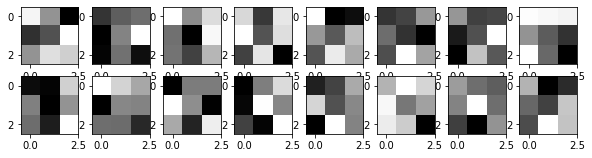

In [78]:


# the total filter in previous layers will be obtained from w.shape[1]
total_filters_in_prev_layers = 16

cols = 8
rows = 8
# rows * cols > total_filters

# current_filter = which filter's weights we want to see
current_filter = 10

fig = plt.figure(figsize=(10, 10))

for each_depth in range(w.shape[1]):
    fig.add_subplot(rows, cols, each_depth+1)
    plt.imshow(w[current_filter][each_depth], cmap='gray')

In [108]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(xtrain_img[10].reshape(1,50,50,len(params)))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

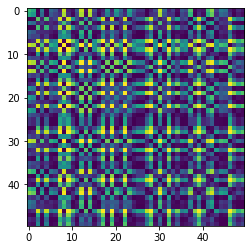

In [109]:
plt.imshow(xtrain_img[10][:,:,0])

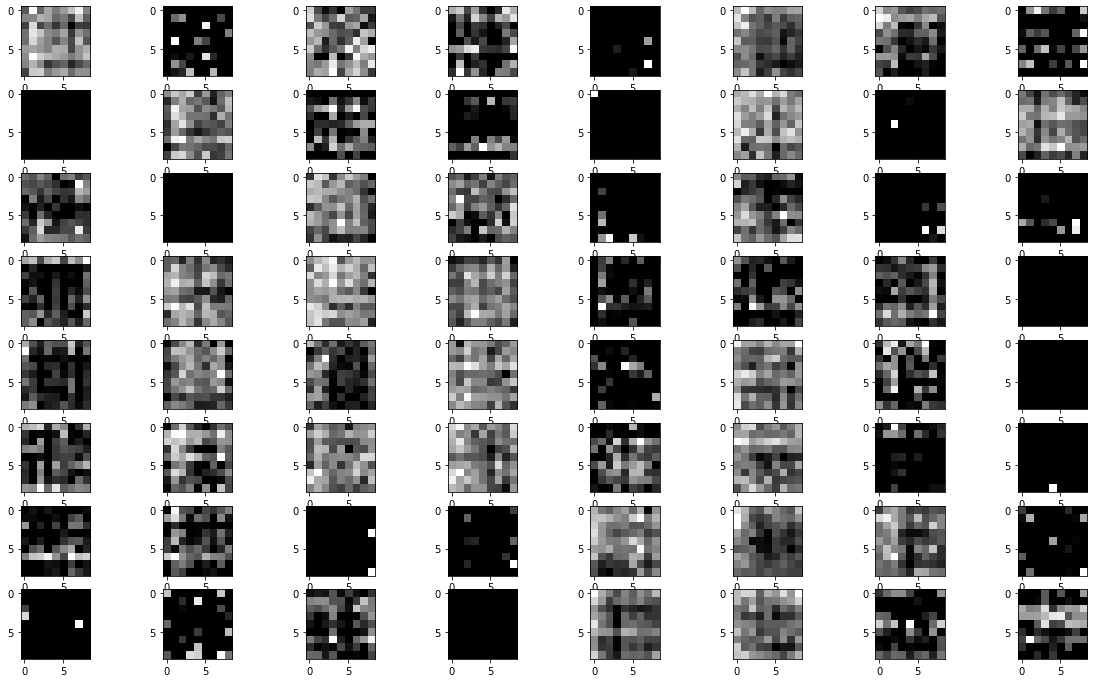

In [114]:
display_activation(activations, 8, 8, 6)

#### Приложение

In [43]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [41]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()